<a href="https://colab.research.google.com/github/navidh86/perturbseq-10701/blob/master/nt_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ONLY FOR COLAB
!git clone https://github.com/navidh86/perturbseq-10701.git
%cd ./perturbseq-10701
!pip install fastparquet tqdm


Cloning into 'perturbseq-10701'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 246 (delta 6), reused 9 (delta 3), pack-reused 230 (from 1)
Receiving objects: 100% (246/246), 329.68 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (65/65), done.
/content/perturbseq-10701
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.3 MB/s eta 0:00:00


In [2]:

!pip install --upgrade git+https://github.com/huggingface/transformers.git


  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-1h_sspra
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-1h_sspra
  Resolved https://github.com/huggingface/transformers.git to commit a48d68c6b06172938948eef457ebb7bcd5dcb77c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 9.8 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=10861344 sha256=8e9edd4dd2ae945b1f34466760aa34e627e00f39994d54331caf630f3c91d669
  Stored in directory: /tmp/pip-ephem-wheel-cache-9unaxo39/wheels/54/cb/3f/83103de5575c534436d6a4686686dead458238dfaf1147e98d
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hu

In [3]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForMaskedLM

import os
import pickle
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from data.reference_data_classification import (
    PairPerturbSeqDataset,
    perturbseq_collate_2,
    get_dataloader,
)

train_loader = get_dataloader(
    parquet_path="data/tf_gene_expression_labeled_v2.parquet",
    tf_sequences_path="data/tf_sequences.pkl",
    gene_sequences_path="data/gene_sequences_4000bp.pkl",
    batch_size=128,
    type="train",
    majority_fraction=0.005,
)

val_loader = get_dataloader(
    parquet_path="data/tf_gene_expression_labeled_v2.parquet",
    tf_sequences_path="data/tf_sequences.pkl",
    gene_sequences_path="data/gene_sequences_4000bp.pkl",
    batch_size=256,
    type="val",
    majority_fraction=0.005,
)

test_loader = get_dataloader(
    parquet_path="data/tf_gene_expression_labeled_v2.parquet",
    tf_sequences_path="data/tf_sequences.pkl",
    gene_sequences_path="data/gene_sequences_4000bp.pkl",
    batch_size=256,
    type="test",
    majority_fraction=0.005,
)

print("Train batches:", len(train_loader.dataset))
print("Val batches:", len(val_loader.dataset))
print("Test batches:", len(test_loader.dataset))



Train batches: 10845
Val batches: 2324
Test batches: 2325


In [5]:
# load NT sequence embeddings
tf_embed_cache = pickle.load(open("./embeds/tf_cls.pkl", "rb"))
gene_embed_cache = pickle.load(open("./embeds/gn_cls.pkl", "rb"))

# ensure everything is torch tensors
for k in tf_embed_cache:
    if not isinstance(tf_embed_cache[k], torch.Tensor):
        tf_embed_cache[k] = torch.tensor(tf_embed_cache[k], dtype=torch.float32)

for k in gene_embed_cache:
    if not isinstance(gene_embed_cache[k], torch.Tensor):
        gene_embed_cache[k] = torch.tensor(gene_embed_cache[k], dtype=torch.float32)

first_tf = next(iter(tf_embed_cache.values()))
first_gene = next(iter(gene_embed_cache.values()))
print("TF emb dim:", first_tf.shape)
print("Gene emb dim:", first_gene.shape)


TF emb dim: torch.Size([1280])
Gene emb dim: torch.Size([1280])


In [6]:
train_ds = train_loader.dataset
val_ds = val_loader.dataset
test_ds = test_loader.dataset

# Use all TF/gene names across ALL splits
combined_df = pd.concat([train_ds.df, val_ds.df, test_ds.df]).reset_index(drop=True)

tf_names = sorted(combined_df["tf_name"].unique().tolist())
gene_names = sorted(combined_df["gene_name"].unique().tolist())

tf_id_map = {name: idx for idx, name in enumerate(tf_names)}
gene_id_map = {name: idx for idx, name in enumerate(gene_names)}

print("Num TF IDs:", len(tf_id_map))
print("Num Gene IDs:", len(gene_id_map))

# check if each TF/gene has an embedding
missing_tf = [n for n in tf_names if n not in tf_embed_cache]
missing_gene = [n for n in gene_names if n not in gene_embed_cache]
print("Missing TF in cache:", len(missing_tf))
print("Missing gene in cache:", len(missing_gene))


Num TF IDs: 223
Num Gene IDs: 4539
Missing TF in cache: 0
Missing gene in cache: 0


In [7]:
class MLP(nn.Module):
    def __init__(self, tf_embed_cache, gene_embed_cache, hidden_dim=1024, num_classes=3):
        super().__init__()

        self.tf_embed_cache = tf_embed_cache
        self.gene_embed_cache = gene_embed_cache

        tf_dim = next(iter(tf_embed_cache.values())).shape[0]
        gene_dim = next(iter(gene_embed_cache.values())).shape[0]

        in_dim = tf_dim + gene_dim   # 1280 + 1280

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),

            nn.Linear(hidden_dim // 2, 128),
            nn.ReLU(),

            nn.Linear(128, num_classes)   # logits for 3 classes
        )

    def forward(self, batch_x):
        """
        batch_x = list of dicts:
        [
           {"tf_name": ..., "gene_name": ...},
           ...
        ]
        """
        vectors = []

        for item in batch_x:
            tf_vec = self.tf_embed_cache[item["tf_name"]]
            gene_vec = self.gene_embed_cache[item["gene_name"]]
            pair_vec = torch.cat([tf_vec, gene_vec], dim=-1)
            vectors.append(pair_vec)

        X = torch.stack(vectors).to(device)
        return self.net(X)   # shape (batch, 3)


In [8]:
class InteractionMLP(nn.Module):
    def __init__(self, tf_embed_cache, gene_embed_cache, hidden_dim=1024, num_classes=3):
        super().__init__()

        self.tf_cache = tf_embed_cache
        self.gene_cache = gene_embed_cache

        tf_dim = next(iter(tf_embed_cache.values())).shape[0]
        gene_dim = next(iter(gene_embed_cache.values())).shape[0]

        in_dim = tf_dim + gene_dim + tf_dim  # concat + product

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),

            nn.Linear(hidden_dim//2, 128),
            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, batch_x):
        vecs = []
        for item in batch_x:
            tf = self.tf_cache[item["tf_name"]]
            gene = self.gene_cache[item["gene_name"]]
            inter = tf * gene  # IMPORTANT
            vecs.append(torch.cat([tf, gene, inter], dim=-1))
        x = torch.stack(vecs).to(device)
        return self.net(x)

    def extract_hidden(self, batch_x):
      """Return the hidden representation before the final classification layer."""

      vecs = []
      for item in batch_x:
          tf = self.tf_cache[item["tf_name"]]
          gene = self.gene_cache[item["gene_name"]]
          inter = tf * gene
          vecs.append(torch.cat([tf, gene, inter], dim=-1))

      x = torch.stack(vecs).to(device)

      # Pass through all layers EXCEPT the final classification layer
      # Because Sequential slicing doesn't work, call layers manually
      h = x
      h = self.net[0](h)   # Linear
      h = self.net[1](h)   # ReLU
      h = self.net[2](h)   # Dropout

      h = self.net[3](h)
      h = self.net[4](h)
      h = self.net[5](h)

      h = self.net[6](h)
      h = self.net[7](h)

      h = self.net[8](h)
      h = self.net[9](h)

      return h    # shape: (batch, 128)



In [9]:
loss_fn = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for batch_x, batch_y in loader:
        batch_y = batch_y.to(device)

        logits = model(batch_x)  # shape (B, 3)
        loss = loss_fn(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        total_loss += loss.item() * len(batch_y)
        total_correct += (preds == batch_y).sum().item()
        total_samples += len(batch_y)

    return total_loss/total_samples, total_correct/total_samples


In [10]:
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report

loss_fn = nn.CrossEntropyLoss()

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    all_preds = []
    all_labels = []

    for batch_x, batch_y in loader:
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = loss_fn(logits, batch_y)

        preds = logits.argmax(dim=1)

        total_loss += loss.item() * len(batch_y)
        total_correct += (preds == batch_y).sum().item()
        total_samples += len(batch_y)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, accuracy, macro_f1, all_labels, all_preds


In [14]:
model = InteractionMLP(
    tf_embed_cache=tf_embed_cache,
    gene_embed_cache=gene_embed_cache,
    hidden_dim=1024,
    num_classes=3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()


In [20]:
best_val_f1 = -1
best_state = None
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        torch.save(best_state, "best_interaction_mlp.pt")
        print(f"** Saved best model at epoch {epoch} (Val F1={val_f1:.4f})")

print("\nBest Val F1:", best_val_f1)


Epoch 01 | Train Loss: 0.8775, Train Acc: 0.5746 | Val Loss: 0.8706, Val Acc: 0.5830, Val F1: 0.5872
** Saved best model at epoch 1 (Val F1=0.5872)
Epoch 02 | Train Loss: 0.8727, Train Acc: 0.5773 | Val Loss: 0.8663, Val Acc: 0.5856, Val F1: 0.5907
** Saved best model at epoch 2 (Val F1=0.5907)
Epoch 03 | Train Loss: 0.8601, Train Acc: 0.5855 | Val Loss: 0.8511, Val Acc: 0.5899, Val F1: 0.5865
Epoch 04 | Train Loss: 0.8493, Train Acc: 0.5911 | Val Loss: 0.8462, Val Acc: 0.5942, Val F1: 0.5898
Epoch 05 | Train Loss: 0.8653, Train Acc: 0.5742 | Val Loss: 0.9118, Val Acc: 0.5452, Val F1: 0.5427
Epoch 06 | Train Loss: 0.8524, Train Acc: 0.5921 | Val Loss: 0.8429, Val Acc: 0.5985, Val F1: 0.5975
** Saved best model at epoch 6 (Val F1=0.5975)
Epoch 07 | Train Loss: 0.8616, Train Acc: 0.5843 | Val Loss: 0.8427, Val Acc: 0.6003, Val F1: 0.5992
** Saved best model at epoch 7 (Val F1=0.5992)
Epoch 08 | Train Loss: 0.8534, Train Acc: 0.5869 | Val Loss: 0.9673, Val Acc: 0.5284, Val F1: 0.4967
Epoc

In [21]:
# Load best checkpoint
model.load_state_dict(torch.load("best_interaction_mlp.pt"))

test_loss, test_acc, test_f1, y_true, y_pred = eval_model(model, test_loader)

print("\n====== FINAL TEST RESULTS ======")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Macro F1:", test_f1)

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))



====== FINAL TEST RESULTS ======
Test Loss: 0.8361167545728786
Test Accuracy: 0.5982795698924731
Test Macro F1: 0.6001540180153855

Classification Report:
              precision    recall  f1-score   support

           0     0.6205    0.5209    0.5664       766
           1     0.6811    0.7538    0.7156       731
           2     0.5052    0.5326    0.5185       828

    accuracy                         0.5983      2325
   macro avg     0.6023    0.6024    0.6002      2325
weighted avg     0.5985    0.5983    0.5962      2325



In [22]:
# =========================
# 1. EXTRACT LATENT EMBEDDINGS FROM TRAIN SET
# =========================
model.eval()

embeds = []
labels = []

for batch_x, batch_y in train_loader:
    h = model.extract_hidden(batch_x)     # <-- uses the helper inside InteractionMLP2
    embeds.append(h.detach().cpu())
    labels.extend(batch_y.cpu().numpy())

embeds = torch.cat(embeds).numpy()
labels = np.array(labels)

print("Latent embedding matrix:", embeds.shape)   # (N, 128)
print("Labels:", labels.shape)




Latent embedding matrix: (10845, 128)
Labels: (10845,)


In [23]:
# =========================
# 2. RUN UMAP
# =========================
!pip install umap-learn --quiet
import umap

reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

umap_emb = reducer.fit_transform(embeds)
print("UMAP output shape:", umap_emb.shape)   # (N, 2)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP output shape: (10845, 2)


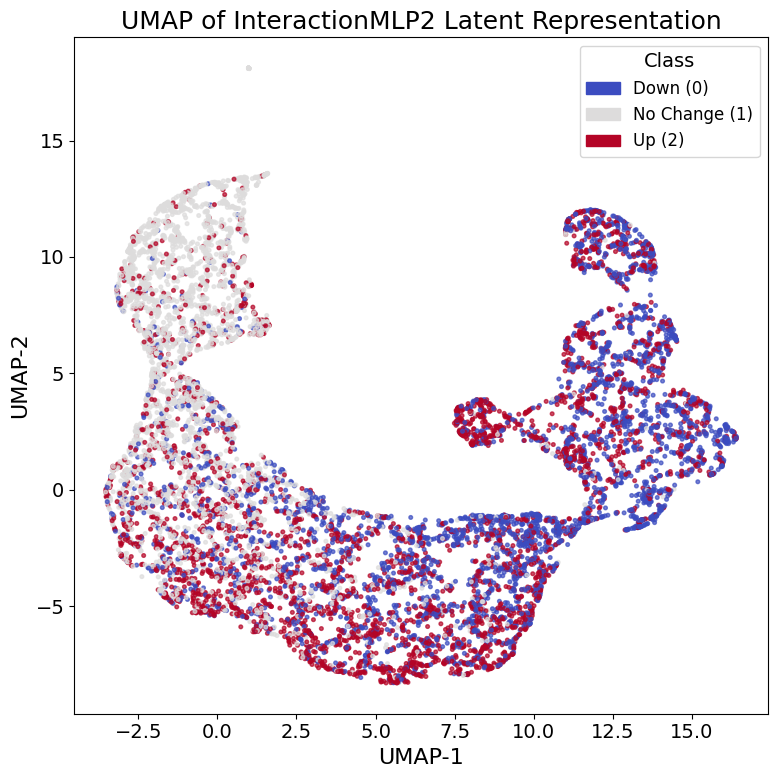

Saved UMAP plot to: results/interaction_mlp_umap.png


In [25]:

# =========================
# 3. PLOT UMAP WITH LEGEND (NO COLORBAR)
# =========================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 14})

scatter = plt.scatter(
    umap_emb[:,0], umap_emb[:,1],
    c=labels,
    cmap="coolwarm",
    s=7,
    alpha=0.7
)

plt.title("UMAP of InteractionMLP2 Latent Representation", fontsize=18)
plt.xlabel("UMAP-1", fontsize=16)
plt.ylabel("UMAP-2", fontsize=16)

# Legend squares (color matched to cmap)
cmap = plt.get_cmap("coolwarm")
legend_handles = [
    mpatches.Patch(color=cmap(0.0), label="Down (0)"),
    mpatches.Patch(color=cmap(0.5), label="No Change (1)"),
    mpatches.Patch(color=cmap(1.0), label="Up (2)")
]

plt.legend(
    handles=legend_handles,
    fontsize=12,
    title="Class",
    title_fontsize=14,
    loc="best"
)

plt.tight_layout()

# =========================
# 4. SAVE FIGURE
# =========================
os.makedirs("results", exist_ok=True)
save_path = "results/interaction_mlp_umap.png"
plt.savefig(save_path, dpi=300)

plt.show()

print(f"Saved UMAP plot to: {save_path}")